In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from joblib import dump, load

from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import TruncatedSVD
import xgboost as xgb

In [159]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

train['train_test'] = 'train'
test['train_test'] = 'test'

data = pd.concat([train, test])

/home/aims/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [160]:
data.shape

(258210, 16)

In [161]:
test.shape

(83210, 16)

In [162]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,NaN,NaN,NaN,train,PORTUGUESE RED,J. Portugal Ramos
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,NaN,NaN,NaN,train,BORDEAUX-STYLE RED BLEND,Château Figeac
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,NaN,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline


In [163]:
data['title'].mode().values


array(['Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)'],
      dtype=object)

In [164]:
data.variety.fillna(value='PINOT NOIR', inplace=True)

In [165]:
data.province.fillna(value='California', inplace=True)

In [166]:
#data = data[pd.notnull(data['variety'])]
#data = data[pd.notnull(data['province'])]

In [167]:
data.taster_name.fillna(value='Roger Voss', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    120975 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 33.5+ MB


In [168]:
data.title.fillna(value='Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma County)', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 258210 entries, 0 to 83209
Data columns (total 16 columns):
country                  258146 non-null object
description              258210 non-null object
designation              181120 non-null object
id                       258210 non-null int64
index                    83210 non-null float64
points                   258210 non-null float64
price                    175000 non-null float64
province                 258210 non-null object
region_1                 215793 non-null object
region_2                 110996 non-null object
taster_name              258210 non-null object
taster_twitter_handle    91559 non-null object
title                    258210 non-null object
train_test               258210 non-null object
variety                  258210 non-null object
winery                   258210 non-null object
dtypes: float64(3), int64(1), object(12)
memory usage: 33.5+ MB


In [169]:
data.title.nunique()

110638

In [170]:
data['province'] = pd.Categorical(data['province'])
proDummies = pd.get_dummies(data['province'], prefix = 'prov')

data['country'] = pd.Categorical(data['country'])
countDummies = pd.get_dummies(data['country'], prefix = 'country')

data['variety'] = pd.Categorical(data['variety'])
varDummies = pd.get_dummies(data['variety'], prefix = 'variety')

data['taster_name'] = pd.Categorical(data['taster_name'])
tastDummies = pd.get_dummies(data['taster_name'], prefix = 'taster')

#data['title'] = pd.Categorical(data['title'])
#titleDummies = pd.get_dummies(data['title'], prefix = 'title')

In [171]:
def getQuality(points):
    if(points <= 85):
        return 'bad'
    elif(points<=90 ):
        return 'ok'
    elif(points<=95):
        return 'good'
    elif(points<=102):
        return 'great'
    else:
        return 'If this gets hit, we did something wrong!'

In [172]:
data['quality'] = data['points'].apply(getQuality)
cleanup_nums = {"quality":     {"ok": 2, "good": 3, "bad": 1, "great": 4},
                "priceRange": {"1-30": 1, "31-50": 2, "51-100": 3, "Above 100": 4}}

data.replace(cleanup_nums, inplace=True)

In [173]:
data.head()

,country,description,designation,id,index,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,train_test,variety,winery,quality
0,Portugal,This is a fine rich balanced wine. It has ripe...,Vila Santa Reserva,32027,NaN,88.870874,20.0,Alentejano,NaN,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,PORTUGUESE RED,J. Portugal Ramos,2
1,France,"A solid, chunky wine, with a structure that is...",NaN,71079,NaN,88.041695,28.0,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Tour Grand Colombier,2
2,France,"This is powerful and concentrated, with the hi...",NaN,32440,NaN,94.085021,130.0,Bordeaux,Saint-Émilion,NaN,Roger Voss,NaN,Gloria Ferrer NV Sonoma Brut Sparkling (Sonoma...,train,BORDEAUX-STYLE RED BLEND,Château Figeac,3
3,US,"Rich, ripe and oaky, this Petite Sirah charms ...",Thompson Vineyard,124405,NaN,89.869797,34.0,California,Santa Barbara County,Central Coast,Roger Voss,NaN,Jaffurs 2010 Thompson Vineyard Petite Sirah (S...,train,PETITE SIRAH,Jaffurs,2
4,US,This wine is a unique in the state blend and f...,McKinley Springs Vineyard,33649,NaN,89.017651,24.0,Washington,Horse Heaven Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Syncline 2016 McKinley Springs Vineyard Rosé (...,train,ROSé,Syncline,2


In [174]:
def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [175]:
data["description"] = data["description"].str.replace('\d+', '')
data["description"] = data.description.apply(func=remove_punctuation)
data["description"] = data.description.apply(func=make_lower_case)

In [176]:
data["variety"] = data["variety"].str.replace('\d+', '')
data["variety"] = data.variety.apply(func=remove_punctuation)
data["variety"] = data.variety.apply(func=make_lower_case)

In [177]:
data["title"] = data["title"].str.replace('\d+', '')
data["title"] = data.title.apply(func=remove_punctuation)
data["title"] = data.title.apply(func=make_lower_case)

In [178]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=10)

In [179]:
#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(data.description)
desc_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["description_" + s for s in collist]
desc_features.columns = collist
desc_features.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9
0,0.115367,0.004648,0.114765,0.051769,0.006326,-0.029204,-0.024298,0.042766,-0.035276,-0.015061
1,0.119707,0.024681,0.072166,0.021039,-0.010886,-0.062698,-0.003105,0.031153,-0.018417,0.017819
2,0.129262,0.101609,0.087649,0.003941,0.131871,-0.032271,-0.016061,0.000618,-0.068737,0.000890
3,0.103500,0.062096,0.012579,-0.064223,-0.019414,-0.064939,-0.015431,-0.010611,-0.044503,0.052991
4,0.096223,-0.056806,-0.015146,-0.013501,0.023782,0.026488,0.003527,0.016375,0.029604,0.018516


In [180]:
tfidf_matrix = tf.fit_transform(data.variety)
var_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["variety_" + s for s in collist]
var_features.columns = collist
var_features.head()

,variety_0,variety_1,variety_2,variety_3,variety_4,variety_5,variety_6,variety_7,variety_8,variety_9
0,2.043681e-06,1.389871e-05,4.913901e-02,2.476389e-01,-0.000093,0.000526,0.000098,-0.000004,0.000202,-0.182886
1,1.003610e-05,4.071077e-05,1.488025e-01,7.480540e-01,-0.000054,0.000804,0.000128,-0.000114,-0.000339,0.613487
2,1.003610e-05,4.071077e-05,1.488025e-01,7.480540e-01,-0.000054,0.000804,0.000128,-0.000114,-0.000339,0.613487
3,1.079418e-06,-7.506918e-07,3.932954e-07,-2.194007e-07,0.000110,-0.000197,0.000805,-0.000082,-0.000196,0.000606
4,2.157955e-07,-1.438726e-07,9.128785e-07,4.021449e-06,0.000020,-0.000030,-0.000013,-0.000012,-0.000283,0.000027


In [181]:
prov_features = pd.DataFrame(svd.fit_transform(proDummies.values))
collist = map(str, range(0, 10))
collist = ["province_" + s for s in collist]
prov_features.columns = collist
prov_features.head()

,province_0,province_1,province_2,province_3,province_4,province_5,province_6,province_7,province_8,province_9
0,-1.240581e-09,-7.569232e-07,-4.043857e-05,-6.677062e-05,2.798547e-06,1.605736e-04,5.151599e-06,4.321171e-04,1.188846e-04,2.012438e-04
1,-1.812014e-11,-6.921262e-08,1.256898e-06,1.973279e-06,-3.596272e-06,-4.683892e-06,9.999948e-01,-6.390981e-05,-2.491000e-05,-4.116232e-05
2,-1.812006e-11,-6.921247e-08,1.256896e-06,1.973275e-06,-3.596272e-06,-4.683892e-06,9.999948e-01,-6.390981e-05,-2.491000e-05,-4.116232e-05
3,1.000000e+00,-1.016791e-14,2.190080e-13,-7.036886e-14,-7.728732e-13,-8.916704e-14,8.126976e-14,-1.478709e-13,-4.454791e-13,-3.593600e-14
4,5.234100e-15,1.000000e+00,-5.615506e-09,3.459892e-09,8.554935e-09,2.634537e-09,6.856296e-09,-1.029708e-08,9.574292e-09,-2.493734e-08


In [182]:
#tfidf_matrix = tf.fit_transform(data.region_1)
#reg1_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
#collist = map(str, range(0, 10))
#collist = ["country_" + s for s in collist]
#reg1_features.columns = collist
#reg1_features.head()

In [183]:
country_features = pd.DataFrame(svd.fit_transform(countDummies.values))
collist = map(str, range(0, 10))
collist = ["country_" + s for s in collist]
country_features.columns = collist
country_features.head()

,country_0,country_1,country_2,country_3,country_4,country_5,country_6,country_7,country_8,country_9
0,1.703659e-14,5.247350e-15,-4.840795e-15,-2.935271e-15,-2.722577e-13,1.194271e-13,1.000000e+00,3.942916e-14,6.894859e-15,-5.142976e-15
1,2.693305e-15,5.588192e-13,1.000000e+00,8.867006e-14,1.641141e-15,-2.405932e-15,-1.981421e-15,2.671852e-15,-6.652325e-15,3.573584e-15
2,1.480007e-15,2.412395e-15,1.000000e+00,-1.876503e-12,2.288156e-14,-1.451767e-14,-9.763736e-15,1.804264e-15,2.411202e-15,1.640754e-15
3,1.000000e+00,1.499136e-14,-1.735653e-14,-4.819702e-14,7.378959e-14,3.310796e-14,-3.049481e-13,-9.994765e-15,-7.958493e-15,-1.248188e-17
4,1.000000e+00,-8.076051e-16,1.632763e-15,-1.956048e-14,1.454136e-12,2.238379e-15,7.282084e-13,9.678672e-14,-3.538135e-14,-3.375404e-14


In [184]:
tfidf_matrix = tf.fit_transform(data.title)
title_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 10))
collist = ["title_" + s for s in collist]
title_features.columns = collist
title_features.head()

,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9
0,1.000000,-0.000244,-0.000111,0.000058,0.000060,-0.000057,0.000022,0.000004,-0.000045,-0.000059
1,1.000000,-0.000244,-0.000111,0.000058,0.000060,-0.000057,0.000022,0.000004,-0.000045,-0.000059
2,1.000000,-0.000244,-0.000111,0.000058,0.000060,-0.000057,0.000022,0.000004,-0.000045,-0.000059
3,0.012868,0.045712,0.028373,-0.005573,-0.008297,0.028896,0.001625,-0.007969,0.042380,0.059134
4,0.000022,0.040952,0.023336,-0.002309,-0.016685,0.028672,-0.013874,-0.010703,0.018635,-0.012092


In [185]:
dd = pd.concat([desc_features, var_features, prov_features, country_features,title_features], axis=1)
dd.shape

(258210, 50)

In [186]:
dd.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9
0,0.115367,0.004648,0.114765,0.051769,0.006326,-0.029204,-0.024298,0.042766,-0.035276,-0.015061,...,1.000000,-0.000244,-0.000111,0.000058,0.000060,-0.000057,0.000022,0.000004,-0.000045,-0.000059
1,0.119707,0.024681,0.072166,0.021039,-0.010886,-0.062698,-0.003105,0.031153,-0.018417,0.017819,...,1.000000,-0.000244,-0.000111,0.000058,0.000060,-0.000057,0.000022,0.000004,-0.000045,-0.000059
2,0.129262,0.101609,0.087649,0.003941,0.131871,-0.032271,-0.016061,0.000618,-0.068737,0.000890,...,1.000000,-0.000244,-0.000111,0.000058,0.000060,-0.000057,0.000022,0.000004,-0.000045,-0.000059
3,0.103500,0.062096,0.012579,-0.064223,-0.019414,-0.064939,-0.015431,-0.010611,-0.044503,0.052991,...,0.012868,0.045712,0.028373,-0.005573,-0.008297,0.028896,0.001625,-0.007969,0.042380,0.059134
4,0.096223,-0.056806,-0.015146,-0.013501,0.023782,0.026488,0.003527,0.016375,0.029604,0.018516,...,0.000022,0.040952,0.023336,-0.002309,-0.016685,0.028672,-0.013874,-0.010703,0.018635,-0.012092


In [187]:
dd.columns

Index(['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9', 'country_0', 'country_1', 'country_2',
       'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
       'country_8', 'country_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9'],
      dtype='object')

In [188]:
#data.drop('index', axis=1, inplace=True)

In [189]:
dd['train_test'] = data.train_test.values

In [190]:
dd['id'] = data.id.values

In [191]:
dd['quality'] = data.quality.values

In [192]:
dd['points'] = data.points.values

In [193]:
dd['price'] = data.price.values

In [194]:
#['id', 'points', 'quality', 'price']
final_data = dd.copy()
final_data.shape

(258210, 55)

In [195]:
# print(train_data.shape)
# print(test_data.shape)

In [196]:
final_data['sum_desc'] = final_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9']].sum(axis=1)

In [197]:
final_data['sum_var'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)

In [198]:
final_data['sum_prov'] = final_data[['province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9']].sum(axis=1)

In [351]:
final_data['sum_country'] = final_data[['variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9']].sum(axis=1)

In [352]:
final_data.head()

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,title_9,id,quality,points,sum_desc,sum_var,sum_prov,sum_country,train_test,price
0,0.536308,0.499766,0.694062,0.605231,0.241022,0.324518,0.393314,0.607184,0.383449,0.444087,...,0.315928,0.212199,0.333333,0.448627,0.575127,0.089270,0.012973,0.867082,train,20.0
1,0.556484,0.542347,0.584460,0.527681,0.215153,0.236280,0.443523,0.576730,0.430064,0.534448,...,0.315928,0.470943,0.333333,0.408345,0.546581,1.000000,0.999758,2.282451,train,28.0
2,0.600902,0.705857,0.624297,0.484532,0.429715,0.316438,0.412828,0.496656,0.290929,0.487923,...,0.315928,0.214935,0.666667,0.701932,0.650819,1.000000,0.999758,2.282451,train,130.0
3,0.481141,0.621872,0.431150,0.312513,0.202335,0.230375,0.414321,0.467209,0.357937,0.631111,...,0.372638,0.824262,0.333333,0.497155,0.419626,0.015175,0.999896,0.794170,train,34.0
4,0.447313,0.369146,0.359818,0.440516,0.267258,0.471236,0.459236,0.537976,0.562845,0.536365,...,0.304400,0.222946,0.333333,0.455757,0.502430,0.014306,0.999896,0.792788,train,24.0


In [307]:
# final_data['country3_8'] = final_data.quality*(final_data.country_1+final_data.country_3+final_data.country_4+final_data.country_5+final_data.country_6+final_data.country_7+final_data.country_8)

In [314]:
from sklearn import preprocessing


x = final_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9', 'country_0', 'country_1', 'country_2',
       'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
       'country_8', 'country_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9',
        'id', 'quality', 'points', 'sum_desc', 'sum_var',
       'sum_prov', 'sum_country']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.columns = ['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9', 'country_0', 'country_1', 'country_2',
       'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
       'country_8', 'country_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9',
        'id', 'quality', 'points', 'sum_desc', 'sum_var',
       'sum_prov', 'sum_country']
df.head(2)

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,title_7,title_8,title_9,id,quality,points,sum_desc,sum_var,sum_prov,sum_country
0,0.536308,0.499766,0.694062,0.605231,0.241022,0.324518,0.393314,0.607184,0.383449,0.444087,...,0.275691,0.290117,0.315928,0.212199,0.333333,0.448627,0.575127,0.08927,0.012973,0.08927
1,0.556484,0.542347,0.584460,0.527681,0.215153,0.236280,0.443523,0.576730,0.430064,0.534448,...,0.275691,0.290117,0.315928,0.470943,0.333333,0.408345,0.546581,1.00000,0.999758,1.00000


In [316]:
final_data = pd.concat([df,final_data['train_test'],final_data['price']],axis = 1)

In [317]:
train_data = final_data[final_data['train_test'] == 'train']
test_data = final_data[final_data['train_test'] == 'test']

In [318]:
train_data.head(2)

,description_0,description_1,description_2,description_3,description_4,description_5,description_6,description_7,description_8,description_9,...,title_9,id,quality,points,sum_desc,sum_var,sum_prov,sum_country,train_test,price
0,0.536308,0.499766,0.694062,0.605231,0.241022,0.324518,0.393314,0.607184,0.383449,0.444087,...,0.315928,0.212199,0.333333,0.448627,0.575127,0.08927,0.012973,0.08927,train,20.0
1,0.556484,0.542347,0.584460,0.527681,0.215153,0.236280,0.443523,0.576730,0.430064,0.534448,...,0.315928,0.470943,0.333333,0.408345,0.546581,1.00000,0.999758,1.00000,train,28.0


In [331]:
X = train_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9', 'country_0', 'country_1', 'country_2',
       'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
       'country_8', 'country_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9',
        'id', 'quality', 'points', 'sum_desc', 'sum_var',
       'sum_prov', 'sum_country']]
y = train_data["price"]

In [332]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [333]:
print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

(52500, 57) (52500,) (122500, 57) (122500,)


In [334]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/home/aims/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [339]:
#Set xgboost parameters
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 6
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtrain, 'train')]
num_round = 20

#Train model
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-mae:14.9604
[1]	train-mae:14.5452
[2]	train-mae:14.3059
[3]	train-mae:14.1895
[4]	train-mae:14.0269
[5]	train-mae:13.9446
[6]	train-mae:13.8154
[7]	train-mae:13.7277
[8]	train-mae:13.6385
[9]	train-mae:13.595
[10]	train-mae:13.5072
[11]	train-mae:13.4785
[12]	train-mae:13.4861
[13]	train-mae:13.4751
[14]	train-mae:13.4788
[15]	train-mae:13.4924
[16]	train-mae:13.486
[17]	train-mae:13.5231
[18]	train-mae:13.4795
[19]	train-mae:13.4624


In [340]:
pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

In [341]:
rmse = np.round(np.sqrt(mean_squared_error(y_true=pred["price"], y_pred=pred["prediction"])), 2)
print ("Mean Squared Error: {} ".format(rmse))

Mean Squared Error: 33.15 


In [342]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

In [343]:
lm = Ridge()

lm.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [353]:
print(lm.intercept_)

-17.934834110697373


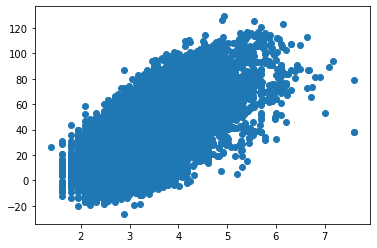

In [354]:
predictions = lm.predict(X_test)
plt.scatter(np.log(y_test),predictions)

In [346]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

RMSE: 33.202166559711905


In [347]:
# rf = RandomForestRegressor()

In [349]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

In [350]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [355]:
predicts = rf.predict(X_test)

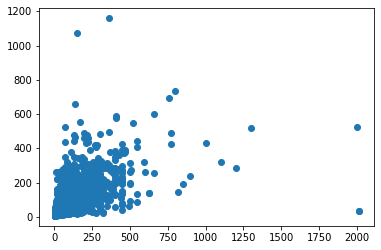

In [356]:
plt.scatter(y_test, predicts)

In [357]:
print('RMSE:', np.sqrt(mean_squared_error(y_test, predicts)))

RMSE: 27.097881576082834


In [78]:
#features_label = X.columns[:]
#importances = rf.feature_importances_
#indices = np. argsort(importances)[::-1]
#for i in range(X.shape[1]):
    #print ("%2d) %-*s %f" % (i + 1, 30, features_label[i],importances[indices[i]]))

## XGB

In [238]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

xgb_model.fit(X_train,y_train)

/home/aims/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:03:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [240]:
xgby_pred = xgb_model.predict(X_test)
print('xjb RMSE:', np.sqrt(mean_squared_error(y_test, xgby_pred)))


xjb RMSE: 25.569298053294116


In [79]:
#print(test_data.columns.tolist())

In [241]:
X_test = test_data[['description_0', 'description_1', 'description_2', 'description_3',
       'description_4', 'description_5', 'description_6', 'description_7',
       'description_8', 'description_9', 'variety_0', 'variety_1', 'variety_2',
       'variety_3', 'variety_4', 'variety_5', 'variety_6', 'variety_7',
       'variety_8', 'variety_9', 'province_0', 'province_1', 'province_2',
       'province_3', 'province_4', 'province_5', 'province_6', 'province_7',
       'province_8', 'province_9', 'country_0', 'country_1', 'country_2',
       'country_3', 'country_4', 'country_5', 'country_6', 'country_7',
       'country_8', 'country_9', 'title_0', 'title_1', 'title_2', 'title_3',
       'title_4', 'title_5', 'title_6', 'title_7', 'title_8', 'title_9',
                'id', 'quality', 'points', 'sum_desc', 'sum_var',
       'sum_prov', 'sum_country']]

In [242]:
test_data['price'] = rf.predict(X_test)
test_data['price'].head()

/home/aims/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


175000    194.783
175001     61.637
175002     45.389
175003     38.451
175004     16.789
Name: price, dtype: float64

[Text(0, 0, 'description_0'),
 Text(0, 0, 'description_1'),
 Text(0, 0, 'description_2'),
 Text(0, 0, 'description_3'),
 Text(0, 0, 'description_4'),
 Text(0, 0, 'description_5'),
 Text(0, 0, 'description_6'),
 Text(0, 0, 'description_7'),
 Text(0, 0, 'description_8'),
 Text(0, 0, 'description_9'),
 Text(0, 0, 'variety_0'),
 Text(0, 0, 'variety_1'),
 Text(0, 0, 'variety_2'),
 Text(0, 0, 'variety_3'),
 Text(0, 0, 'variety_4'),
 Text(0, 0, 'variety_5'),
 Text(0, 0, 'variety_6'),
 Text(0, 0, 'variety_7'),
 Text(0, 0, 'variety_8'),
 Text(0, 0, 'variety_9'),
 Text(0, 0, 'province_0'),
 Text(0, 0, 'province_1'),
 Text(0, 0, 'province_2'),
 Text(0, 0, 'province_3'),
 Text(0, 0, 'province_4'),
 Text(0, 0, 'province_5'),
 Text(0, 0, 'province_6'),
 Text(0, 0, 'province_7'),
 Text(0, 0, 'province_8'),
 Text(0, 0, 'province_9'),
 Text(0, 0, 'country_0'),
 Text(0, 0, 'country_1'),
 Text(0, 0, 'country_2'),
 Text(0, 0, 'country_3'),
 Text(0, 0, 'country_4'),
 Text(0, 0, 'country_5'),
 Text(0, 0, 'c

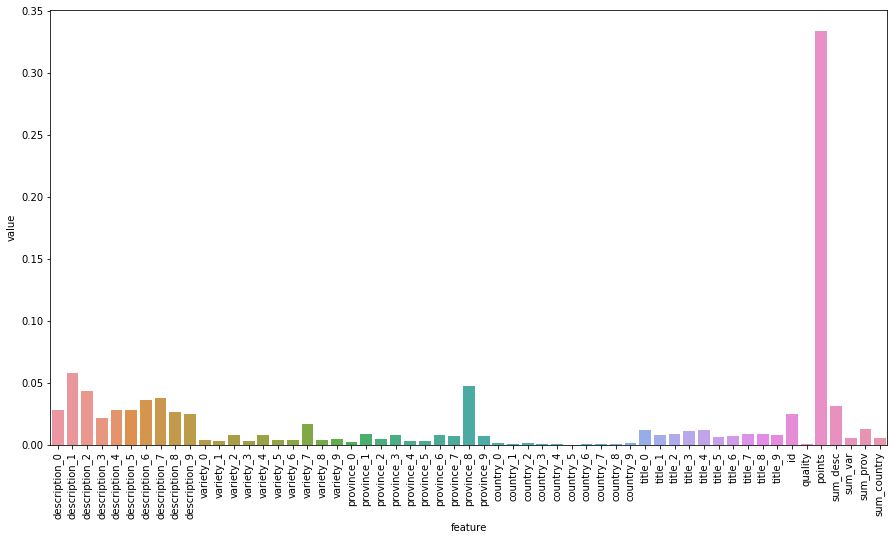

In [243]:
importance = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(rf.feature_importances_)],axis=1)
importance.columns = ['feature','value']

plt.figure(figsize=(15,8))
sns.barplot(x="feature", y="value", data=importance).set_xticklabels(rotation=90,labels=X_train.columns)

In [244]:
test_data[['id', 'price']].to_csv('bma_price_predicted22.csv', index=False)

In [86]:
#pd.DataFrame(test_data_sss).to_csv('random_f.csv')

In [245]:
import pickle

In [246]:
pickle.dump(rf,open('rf_model22.sav','wb'))